In [333]:
import numpy as np
import matplotlib.pyplot as plt

def findLocalArgExt(f, apoly, a, b):
    """
    Function to find the indices at which local minima and maxima occur in the error function
    apoly: Array of coefficients of approximating polynomial
    a,b: Endpoints of approximation interval [a,b]
    """
    x = np.linspace(a,b,num=1000)
    E_f = np.polyval(np.flip(apoly), x) - f(x)
    argmax = []#List of arguments at which the local maxima occur
    argmin = []#List of arguments at which local minima occur
    #Find indices at which local maxima and minima occur
    for i in np.arange(len(x)):
        if i != 0 and i != (len(x) - 1):
            if E_f[i] > E_f[i-1] and E_f[i] > E_f[i+1]:
                argmax.append(x[i])
            elif E_f[i] < E_f[i-1] and E_f[i] < E_f[i+1]:
                argmin.append(x[i])
    if E_f[0] > E_f[1]:
        argmax.append(x[0])
    elif E_f[0] < E_f[1]:
        argmin.append(x[0])

    if E_f[len(x) - 1] > E_f[len(x) - 2]:
        argmax.append(x[len(x) - 1])
    elif E_f[len(x) - 1] < E_f[len(x) - 2]:
        argmin.append(x[len(x) - 1])

    result = np.concatenate((np.array(argmax), np.array(argmin)))#Cast to numpy array
    return np.sort(result)

def ensureAlternationProperty(E_arr):
    """
    Function that returns an integer array v indicating which indices to extract from new_test_points
    in the function exchange() to ensure the alternation property holds for the selected test points
    that will be used in the next iteration, i.e. new_test_points[v[i]] will be extracted for i = 0,1,...,len(v) - 1
    E_arr: Values of error function evaluated at test points
    """
    J = len(E_arr)
    j = 0
    v = np.zeros(J, dtype=int)
    xe = E_arr[0]
    xv = 1
    for k in np.arange(1,J):
        if np.sign(E_arr[k]) == np.sign(xe):
            if np.abs(E_arr[k]) > np.abs(xe):
                xe = E_arr[k]#Element of max. value in E_arr
                xv = k
        else:
            v[j] = xv
            j = j + 1
            xe = E_arr[k]
            xv = k
    v[j] = xv
    return v

def exchange(f, sol_vec, prev_test_points, a, b):
    """
    Function to update find the alternation points of the polynomial with coefficients specified by coefs
    sol_vec: Result of solving remez system. Coefficients of approximating polynomial occupy the first N + 1 indices,
             in ascending degree order, in indices 0,1,...,len(coefs) - 2, uniform approximation error term delta
             occupies cell in last index
    prev_test_points: Array of test points before the exchange
    a,b: Endpoints of approximation interval [a,b]
    Returns new array of test points
    """
    N_2 = len(sol_vec)
    approximating_poly = sol_vec[0:(N_2 - 1)]#Coefficients of polynomial
    delta = sol_vec[N_2 - 1]
    new_test_points = findLocalArgExt(f, approximating_poly, a, b)
    # E_arr = np.polyval(np.flip(approximating_poly), new_test_points) - (np.exp(new_test_points) + new_test_points + np.ones(len(new_test_points)))
    E_arr = np.polyval(np.flip(approximating_poly), new_test_points) - f(new_test_points)

    v2 = ensureAlternationProperty(E_arr)#Ensure alternation property
    new_test_points = new_test_points[v2]
    #Make sure length of new test points array is correct
    if len(new_test_points) > N_2:
        new_test_points = new_test_points[0:N_2]

    x = np.linspace(a, b, 100)
    error_func = lambda x : np.polyval(np.flip(approximating_poly), x) - f(x)
    plt.plot(x, error_func(x), label="error")
    plt.scatter(new_test_points, error_func(new_test_points), label = 'nodes')

    plt.legend()
    plt.show()

    return np.sort(new_test_points)

def solveRemezSystem(test_points, f):
    """
    Function to find the Chebyschev solution of the linear system of euqations that arises
    in the Remez exchange algorithm
    test_points: Test points
    f: Values of function evaluated at test points, we are solving Ax = f
    Returns a vector of length N + 2, the first N + 1 indices are the coefficients of the polynomial
    in ascending degree order, last index is the max. uniform approximation error delta
    """
    size = len(f)
    A = np.zeros((size,size))
    for i in np.arange(size):
        for j in np.arange(size-1):
            A[i][j] = np.power(test_points[i],j)
    for j in np.arange(size):
        A[j][size-1] = np.power(-1.0,j)
    chebyschev_sol = np.linalg.solve(A,f)
    return chebyschev_sol

def remez(f, N, a, b, tol=1e-3):
    """
    Function to find the minimax interpolating polynomial of degree N to 1/sqrt(1 + x^2) on [a,b]
    N: Degree of interpolating polynomial
    a,b: Endpoints of approximation interval
    tol: Error tolerance in infinity norm, default is 10^-3
    """
    test_points = np.linspace(a, b, num=(N+2))
    f_v = f(test_points) #Function being approximated
    E_0 = np.max(np.abs(f_v))
    E = 1e15
    delta = 0.1
    i = 0;
    while (E - delta)/E_0 >= tol:
        #Solve remez system and update delta
        sol_vec = solveRemezSystem(test_points, f_v)

        approximating_poly = np.flip(sol_vec[0:(len(sol_vec) - 1)])#Polynomial coefficients in ascending degree order
        delta_prev = delta
        delta = sol_vec[len(sol_vec) - 1]#Uniform approximation error
        #Exchange method to find new test points
        test_points = exchange(f, sol_vec, np.copy(test_points), a, b)
        f_v = f(test_points)
        #Update E
        E_arr = np.polyval(approximating_poly, test_points) - f_v#Aray of values of error function at  test points
        E = np.max(np.abs(E_arr))
        i+=1
        print(i)

        x = np.linspace(a, b, 1000)

        plt.plot(x, f(x), label='original')
        plt.plot(x, np.polyval(np.flip(sol_vec), x), label='approx')
        plt.scatter(test_points, f_v, label='nodes')
        plt.legend()
        plt.show()

        if np.max(np.abs(delta_prev - delta)) < tol:
            break
        # plt.plot(np.linspace(a, b, 100), f(np.linspace(a, b, 100)), color='blue', label = 'original')
        # plt.plot(np.linspace(a, b, 100), np.polyval(np.flip(sol_vec), np.linspace(a, b, 100)))
        # plt.show()
    poly_coefs = sol_vec[0:(len(sol_vec) - 1)]#Extract coefficients from solution vector
    return poly_coefs

def run(f, a = 0, b = 2.0, N = 4):
    poly = remez(f, N, a, b, tol=1e-6)
    print(poly)
    x = np.linspace(a,b, num=500)
    # f = np.exp(x) + x + np.ones(len(x))
    plt.plot(x, f(x), color='blue', label = 'original')
    plt.plot(x, np.polyval(np.flip(poly), x), color='green', label = 'remez')

    # plt.ylim(min(f(x)) * 0.9 if min(f(x) > 0) else 1.1, max(f(x)) * 1.1 if max(f(x) > 0) else 0.9)
    plt.legend()
    plt.show()


1
2
3
[ 1.43102721 -0.27007137  1.94743693 -0.61308673  0.22581986]


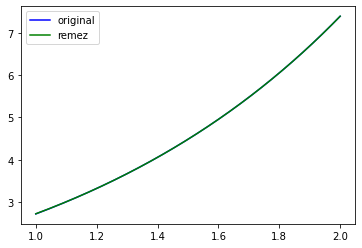

In [317]:
f = lambda x : (np.exp(x))
run(f, a=1, b=2, N=4)

1
2
3
4
5
[ -8.4043603   33.6342701  -41.19996182  20.62649756  -3.65361538]


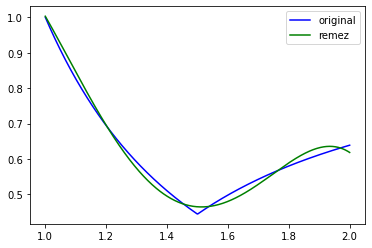

In [318]:
f1 = lambda x: - 1/ (x ** 2)
f = lambda x : np.where(x < 1.5, -f1(x), -2*f1(1.5)+f1(x))
run(f, a=1, b=2, N=4)

1
2
3
[ 3.11385025 -3.83570544  2.33841977 -0.70611734  0.08455127]


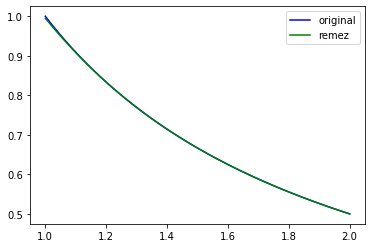

In [319]:
f = lambda x : (1 /x)
run(f, a=1, b=2, N=4)

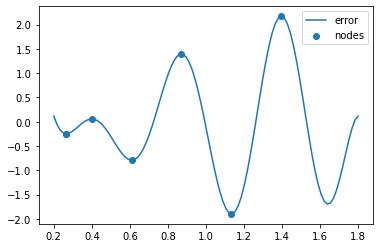

1


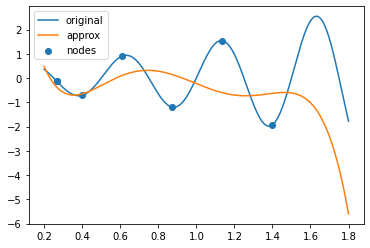

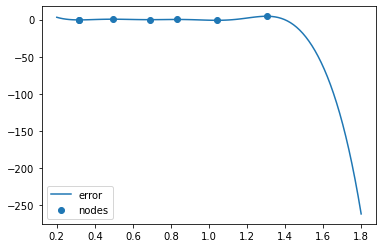

2


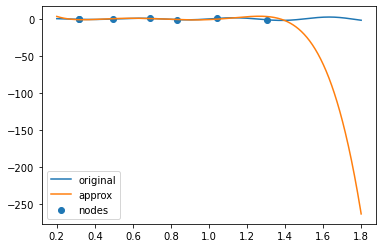

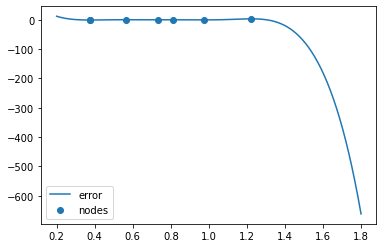

3


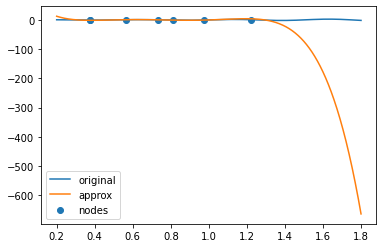

[  121.00045401 -1013.29388692  3149.62262789 -4575.69759401
  3129.63575726  -811.5106182 ]


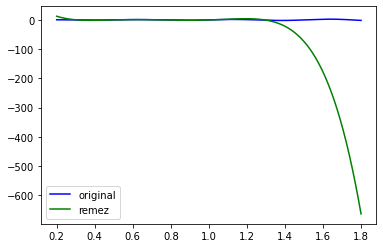

In [334]:
f = lambda x : (np.exp(x) * np.cos(2 * np.pi * x) * np.sin(2 * np.pi * x))
run(f, a=0.2, b=1.8, N=5)

1
2
[ 3.16296737e-02 -2.83814276e-15  8.90833585e+00  1.30111356e-14
 -2.74905163e+01 -1.18449361e-14  2.21405638e+01]


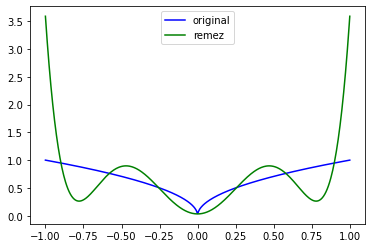

In [324]:
f = lambda x : np.sqrt(np.abs(x))
run(f, a=-1, b=1, N=6)